In [11]:
from ipywidgets import *
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_profiling as pp
import os
import glob
import sys
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneOut
from scipy import stats
from itertools import combinations
from keras.layers import Activation, LSTM, Input, MaxPooling2D, Flatten, Dense, Dropout, Reshape, InputLayer, Conv1D, AveragePooling1D, MaxPooling1D, Conv2D, AveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import LeakyReLU
import keras_metrics
from xgboost import XGBClassifier
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

plt.rcParams["figure.figsize"] = [10,10]
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)
Using TensorFlow backend.


# Read data

In [3]:
full_df = pd.read_pickle("./data/data_first_measurement.pkl")
full_df.head()

TLE        TRE        TLA        TRA        TLL  \
Name      Time                                                              
ARHIPCHUK 00:06:05  38.180571  38.234562  33.480730  33.423765  31.942529   
          00:06:06  38.188642  38.245826  33.488879  33.429575  31.939272   
          00:06:07  38.196713  38.257091  33.497028  33.435385  31.936014   
          00:06:08  38.197452  38.261386  33.497303  33.437303  31.934358   
          00:06:09  38.198191  38.265682  33.497579  33.439222  31.932701   

                          TRL  Load  [W]  HR  [1/min]  VO2/kg  [ml/min/kg]  \
Name      Time                                                               
ARHIPCHUK 00:06:05  31.737343       65.0         95.0               10.800   
          00:06:06  31.740192       65.0         95.0               11.950   
          00:06:07  31.743042       65.0         95.0               13.100   
          00:06:08  31.743920       65.0         95.0               14.675   
          00:06:09  31.744799       65.0         95.0               16.250   

                     RER    V'O2  [ml/min]  V'CO2  [ml/min]  FAT  [g/day]  \
Name      Time                                                              
ARHIPCHUK 00:06:05  0.7500          889.00           663.00      0.982778   
          00:06:06  0.7350          983.50           720.50      0.976392   
          00:06:07  0.7200         1078.00           778.00      0.971934   
          00:06:08  0.7325         1206.75           891.25      0.968768   
          00:06:09  0.7450         1335.50          1004.50      0.966391   

                    CHO  [g/day]  DIFF_FAT_CHO    y  Probability  Time_feature  
Name      Time                                                                  
ARHIPCHUK 00:06:05     -1.483108      1.242050  1.0     0.964938      0.101389  
          00:06:06     -1.480704      1.240784  1.0     0.964938      0.101667  
          00:06:07     -1.478297      1.239212  1.0     0.964938      0.101944  
          00:06:08     -1.475808      1.237392  1.0     0.964938      0.102222  
          00:06:09     -1.473174      1.235379  1.0     0.964938      0.102500

In [6]:
# set lists variables
fat_cols = ['FAT  [g/day]', 'CHO  [g/day]']
all_temp_cols = ["TRE", "TLE", "TLA", "TRA", "TLL", "TRL"]
temp_arms = ['TLE', 'TRE']
temp_arms = all_temp_cols[2:4]
temp_legs = all_temp_cols[4:]
temp_time_cols = temp_cols + ["Time_feature"]
temp_prob_cols = temp_cols + ["Probability"]
subjects = np.array(list(set(full_df.index.get_level_values("Name"))))

# normalize temperatures
full_df_norm = full_df.copy()

# functions for models

In [8]:
def crossvalidate(method, df = full_df,  cols = temp_cols + ["Probability"],nn = False):
    scores = []
    x_axis = []
    y_axis = []
    loo = LeaveOneOut()
    for train, test in loo.split(subjects):
        X_train = np.array(df.loc[subjects[train]][cols])
        y_train = np.array(df.loc[subjects[train]]["y"]).astype(np.integer)

        X_test = np.array(df.loc[subjects[test]][cols])
        y_test = np.array(df.loc[subjects[test]]["y"]).astype(np.integer)
        
        ddf  = full_df.loc[subjects[test]]["y"].to_frame("true")
        
        if nn:
            model = get_model()
            model.fit(X_train, y_train, epochs=10, verbose = 1, batch_size = 80)
            pred = np.where((model.predict(X_test).reshape(-1,)) > 0.5, 1, 0)
            ddf["predict"] = pred
            true_jump = ddf["true"].idxmin()[1].total_seconds()
            predicted_jump = ddf["predict"].idxmin()[1].total_seconds()
            x_axis.append(true_jump)
            y_axis.append(predicted_jump)
            
            scores.append((f1_score(pred,y_test),true_jump - predicted_jump))            
        else:
            method.fit(X_train, y_train)
            pred = method.predict(X_test)
            ddf["predict"] = pred
            true_jump = ddf["true"].idxmin()[1].total_seconds()
            predicted_jump = ddf["predict"].idxmin()[1].total_seconds()
            x_axis.append(true_jump)
            y_axis.append(predicted_jump)
            scores.append((f1_score(pred,y_test),true_jump - predicted_jump))
        
    print(scores)
    print(np.mean(np.abs(np.array(scores)), axis = 0))
    ax = plt.axes()
    ax.set_xlim(300, 900)
    ax.set_ylim(300, 900)
    plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    plt.xlabel("true")
    plt.ylabel("prediction")
    plt.plot(x_axis, y_axis,'ro')
    
def train_test(df, cols, test_size=0.15):
    X = np.array(df[cols])
    y = np.array(df["y"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)
    y_train = y_train.astype(np.integer)
    y_test = y_test.astype(np.integer)
    print("train")
    print(np.bincount(y_train))
    print("test")
    print(np.bincount(y_test))
    
    return X_train, X_test, y_train, y_test

def plot_predictions(method ,cols, df = full_df, sub = subjects[0]):    
    temp_df = pd.DataFrame()
    temp_df["true"] = df.xs(sub)["y"]
    temp_df["predict"] = method.predict(df.xs(sub)[cols].values)
    temp_df["bin_predict"] = np.where(temp_df["predict"].values > 0.5, 1, 0)
    print(temp_df["true"].idxmin().total_seconds() - temp_df["bin_predict"].idxmin().total_seconds())
    temp_df[["true","predict"]].plot()

def plot_all_predictions(method ,cols, df = full_df):
    sub = SelectionSlider(options=subjects)
    interact(lambda subject: plot_predictions(method ,cols, df, sub = subject), subject=sub)

#  6 inputs ( all temps )

In [14]:
X_train, X_test, y_train, y_test = train_test(full_df_norm, all_temp_cols)

train
[6789 4715]
test
[1219  812]


### SVM

In [15]:
svc = svm.SVC(kernel='rbf', C=500)
svc.fit(X_train, y_train)

print("test")
print(f1_score(svc.predict(X_test),y_test))
plot_all_predictions(svc, all_temp_cols, full_df_norm)

test
0.9789081885856079


interactive(children=(SelectionSlider(description='subject', options=('TARANEK', 'VOVA', 'PEREPICA', 'YAN', 'M…

crossvalidate
[(0.0, 183.0), (0.0, 200.0), (0.0, 208.0), (0.6407766990291262, 111.0), (0.664944013781223, 386.0), (0.0, 241.0), (0.5690140845070423, 98.0), (0.5382513661202185, 197.0), (0.6018735362997658, 257.0), (0.0, 289.0), (0.6227390180878553, 241.0), (0.6333973128598849, 138.0), (0.6203346203346203, 241.0), (0.34523809523809523, 330.0), (0.0, 235.0), (0.0, 369.0), (0.22772277227722776, 217.0), (0.0, 191.0), (0.8575342465753425, -104.0), (0.42583732057416274, 178.0), (0.6339794754846066, -321.0), (0.6418918918918919, -212.0)]
[  0.36470611 224.86363636]


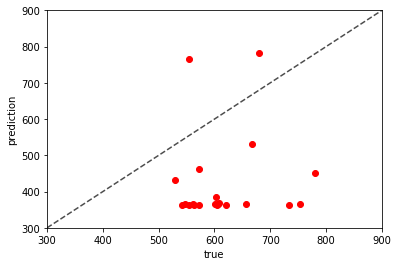

In [16]:
print("crossvalidate")
crossvalidate(svc, full_df_norm, cols = all_temp_cols)

### Random Forest

In [18]:
clf = RandomForestClassifier(n_estimators= 100, max_depth=15, random_state=0)
clf.fit(X_train, y_train)

print("test")
print(f1_score(clf.predict(X_test),y_test))
plot_all_predictions(clf, all_temp_cols, full_df_norm)

test
0.9975308641975309


interactive(children=(SelectionSlider(description='subject', options=('TARANEK', 'VOVA', 'PEREPICA', 'YAN', 'M…

crossvalidate
[(0.6376306620209059, -208.0), (0.0, 200.0), (0.0, 208.0), (0.4782608695652174, 210.0), (0.0, 386.0), (0.0, 241.0), (0.5117004680187207, -313.0), (0.5382513661202185, 197.0), (0.6018735362997658, 257.0), (0.0, 289.0), (0.0, 241.0), (0.7779204107830552, -155.0), (0.6203346203346203, 241.0), (0.0, 417.0), (0.0, 235.0), (0.8540372670807453, 94.0), (0.0, 236.0), (0.0, 191.0), (0.7844660194174757, 112.0), (0.42583732057416274, 178.0), (0.5732349841938883, 120.0), (0.555956678700361, 125.0)]
[  0.33452292 220.63636364]


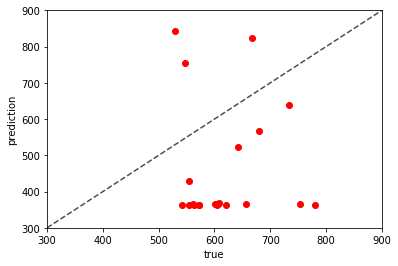

In [19]:
print("crossvalidate")
crossvalidate(clf, full_df_norm, cols = all_temp_cols)

### XG Boost

In [21]:
xg = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
xg.fit(X_train, y_train)
print("test")
print(f1_score(xg.predict(X_test),y_test))
print("feature importances")
print(xg.feature_importances_)

test
0.9963008631319359
feature importances
[0.14675194 0.15079097 0.18983507 0.17165938 0.17401548 0.16694716]


[(0.5604900459418071, -287.0), (0.0, 200.0), (0.0, 208.0), (0.4615384615384615, 210.0), (0.0, 386.0), (0.0, 241.0), (0.5109034267912773, 164.0), (0.5382513661202185, 197.0), (0.6018735362997658, 257.0), (0.0, 289.0), (0.0, 241.0), (0.7390243902439024, -187.0), (0.6203346203346203, 241.0), (0.2923497267759563, 417.0), (0.0, 235.0), (0.8540372670807453, 94.0), (0.0, 236.0), (0.0, 191.0), (0.5675057208237986, 313.0), (0.42583732057416274, 178.0), (0.5677267373380448, 121.0), (0.6246246246246246, 97.0)]
[  0.33474987 226.81818182]


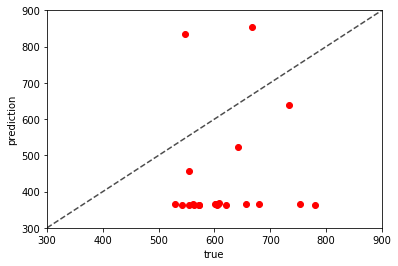

In [22]:
crossvalidate(xg, full_df_norm, cols = all_temp_cols)

# 6 inputs (temperature + time)

In [55]:
temps_6_time = all_temp_cols + ["Time_feature"]
X_train, X_test, y_train, y_test = train_test(full_df_norm, temps_6_time)

train
[6789 4715]
test
[1219  812]


### Random Forest

crossvalidate
[(0.8652482269503545, -57.0), (0.9187935034802784, 2.0), (0.9306487695749441, -31.0), (0.7984790874524714, -35.0), (0.6981450252951096, 179.0), (0.9873949579831932, 6.0), (0.8840970350404312, -43.0), (0.8716814159292036, -44.0), (0.9162210338680927, -47.0), (0.890595009596929, 57.0), (0.8385542168674698, 67.0), (0.9159212880143113, 47.0), (0.8942486085343229, -13.0), (0.6740858505564388, 205.0), (0.908675799086758, 235.0), (0.8229665071770336, 111.0), (0.9957805907172996, -2.0), (0.9813333333333333, 7.0), (0.7725490196078431, 116.0), (0.7370600414078675, -127.0), (0.9348659003831418, 34.0), (0.8899297423887588, -47.0)]
[ 0.86942159 68.72727273]


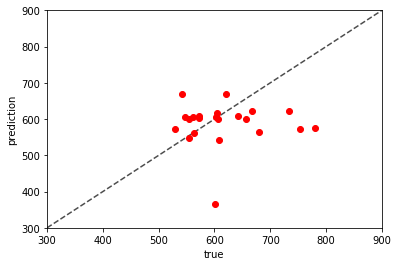

In [24]:
clf = RandomForestClassifier(n_estimators= 100, max_depth=15, random_state=0)
# clf.fit(X_train, y_train)
# print("test")
# print(f1_score(clf.predict(X_test),y_test))
# plot_all_predictions(clf, temps_5_time, full_df_norm)
print("crossvalidate")
crossvalidate(clf, full_df_norm, cols = temps_6_time)

### SVM

[(0.47225806451612906, -29.0), (0.0, 200.0), (0.72, 91.0), (0.997624703087886, -1.0), (0.0, 386.0), (0.6495956873315364, -94.0), (0.870026525198939, -49.0), (0.615625, -246.0), (0.6377171215880894, -292.0), (0.46276595744680854, 202.0), (0.6227390180878553, 241.0), (0.434108527131783, 219.0), (0.7461300309597523, -164.0), (0.5342706502636204, 265.0), (0.008474576271186442, 234.0), (0.3991323210412147, 277.0), (0.8805970149253731, -63.0), (0.0, 191.0), (0.8380187416331996, -121.0), (0.5510835913312694, -253.0), (0.756152125279642, 109.0), (0.6713780918727916, -186.0)]
[  0.53944081 177.86363636]


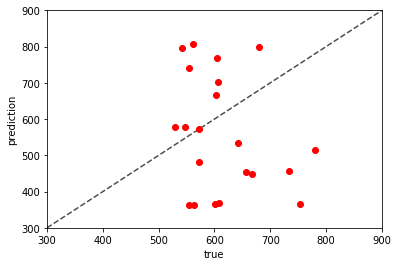

In [25]:
svc = svm.SVC(kernel='rbf', C=500)
# svc.fit(X_train, y_train)
# print("test")
# print(f1_score(svc.predict(X_test),y_test))
# plot_all_predictions(svc, temps_5_time, full_df_norm)
# print("crossvalidate")
crossvalidate(svc, full_df_norm, cols = temps_6_time)

### XG Boost

[(0.8632075471698113, -58.0), (0.704, 34.0), (0.9223946784922394, -35.0), (0.715502555366269, -157.0), (0.6981450252951096, 179.0), (0.7927631578947368, -126.0), (0.9060773480662984, -34.0), (0.9270588235294117, -10.0), (0.9129662522202486, -49.0), (0.8969465648854962, 54.0), (0.8632075471698113, 66.0), (0.7682926829268292, 114.0), (0.8684684684684686, -73.0), (0.7247706422018348, 180.0), (0.9611451942740286, -19.0), (0.8835098335854766, 77.0), (0.9874476987447699, -6.0), (0.9675675675675676, 12.0), (0.8576642335766422, 78.0), (0.8476190476190476, -64.0), (0.9389312977099237, 32.0), (0.8796296296296297, -52.0)]
[ 0.85851435 68.59090909]


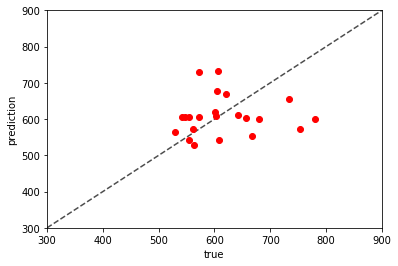

In [33]:
xg = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.1, subsample=0.5)
# xg.fit(X_train, y_train)
# print("test")
# print(f1_score(xg.predict(X_test),y_test))
# print("feature importances")
# print(xg.feature_importances_)
# print("crossvalidate")
crossvalidate(xg, full_df_norm, cols = temps_6_time)

### 3 inputs (temperature + Probability)

In [58]:
temp_6_probability = all_temp_cols + ["Probability"]
X_train, X_test, y_train, y_test = train_test(full_df_norm, temp_6_probability)

train
[6789 4715]
test
[1219  812]


### Random Forest

crossvalidate
[(0.9336734693877551, -26.0), (0.0, 200.0), (0.9803921568627451, 8.0), (0.7969639468690702, -107.0), (0.6573913043478261, 197.0), (0.9875518672199171, 3.0), (0.9136490250696379, -31.0), (0.8365180467091294, -75.0), (0.8970331588132636, -59.0), (0.9053030303030303, 50.0), (0.8413461538461537, 66.0), (0.9081081081081082, 58.0), (0.749611197511664, -75.0), (0.7325227963525835, 176.0), (0.9853249475890985, -7.0), (0.8229665071770336, 111.0), (0.9345372460496614, 29.0), (0.9840425531914894, 6.0), (0.7725490196078431, 116.0), (0.81651376146789, -80.0), (0.9287090558766861, 37.0), (0.8755760368663594, -54.0)]
[ 0.83001288 71.40909091]


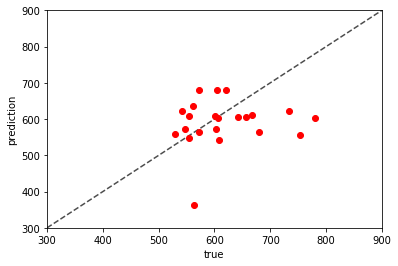

In [29]:
clf = RandomForestClassifier(n_estimators= 120, max_depth=20, random_state=0)
# clf.fit(X_train, y_train)
# print("test")
# print(f1_score(clf.predict(X_test),y_test))
# plot_all_predictions(clf, temps_5_time, full_df_norm)
print("crossvalidate")
crossvalidate(clf, full_df_norm, cols = temp_6_probability)

### SVM

crossvalidate
[(0.7672955974842767, -7.0), (0.0, 200.0), (0.9976019184652278, -1.0), (0.8155339805825244, -95.0), (0.6550522648083624, 198.0), (0.9146110056925997, -37.0), (0.9590643274853802, -14.0), (0.8995433789954338, -44.0), (0.7717717717717717, -145.0), (0.8550295857988166, -98.0), (0.8413461538461537, 66.0), (0.8901098901098902, 60.0), (0.9288888888888889, 32.0), (0.8, 139.0), (0.9936575052854123, -3.0), (0.7610062893081762, 127.0), (0.9978858350951374, -1.0), (0.0, 191.0), (0.8821428571428571, 66.0), (0.0, 178.0), (0.9429657794676806, 30.0), (0.8755760368663594, -54.0)]
[ 0.75223105 81.18181818]


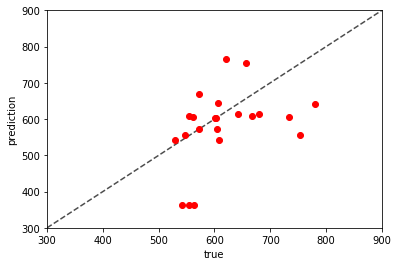

In [30]:
svc = svm.SVC(kernel='rbf', C=100)
# svc.fit(X_train, y_train)
# print("test")
# print(f1_score(svc.predict(X_test),y_test))
# plot_all_predictions(svc, temp_6_probability, full_df_norm)
print("crossvalidate")
crossvalidate(svc, full_df_norm, cols = temp_6_probability)

### XG Boost

[(0.9336734693877551, -26.0), (0.8293736501079914, 8.0), (0.98812351543943, -2.0), (0.7540394973070018, -137.0), (0.6981450252951096, 179.0), (0.8700361010830324, -1.0), (0.9265536723163842, -26.0), (0.8995433789954338, -44.0), (0.9145907473309608, -48.0), (0.9787985865724381, 12.0), (0.8578199052132701, 60.0), (0.7732793522267206, 112.0), (0.8653500897666068, -75.0), (0.7363636363636364, 174.0), (0.9812108559498957, -9.0), (0.8229665071770336, 111.0), (0.9936842105263157, -3.0), (0.9675675675675676, 12.0), (0.7984644913627639, 105.0), (0.839622641509434, -68.0), (0.9287090558766861, 37.0), (0.8796296296296297, -52.0)]
[ 0.87443389 59.13636364]


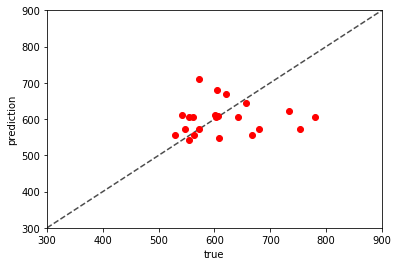

In [32]:
xg = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.1, subsample=0.5)
# xg.fit(X_train, y_train)
# print("test")
# print(f1_score(xg.predict(X_test),y_test))
# print("feature importances")
# print(xg.feature_importances_)
# print("crossvalidate")
crossvalidate(xg, full_df_norm, cols = temp_6_probability)

 ---------------------------------------------------------
 
 
 

#                                                                         window inputs

 ---------------------------------------------------------
 
 
 

In [34]:
window_size = 16

def train_test_window(dataframe = full_df_norm, cols = temp_cols, window_size = 16 , test_size=0.15):
    X = []
    y = []
    for sub in subjects[:-1]:
        df = dataframe.loc[(sub),]
        ids = (len(df) - window_size)
        for j in range(ids):
            X.append(np.array(df[cols][j:j+window_size]))
            y.append(np.array(df[["y"]][j+window_size-1:j+window_size]))
    X = np.array(X)
    y = (np.array(y).reshape(-1,)).astype(np.integer)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    X_ex = []
    y_ex = []
    df = dataframe.loc[subjects[-1]]
    ids = len(df) - window_size
    for j in range(ids):
        X_ex.append(np.array(df[cols][j:j+window_size]))
        y_ex.append(np.array(df[["y"]][j+window_size-1:j+window_size]))
    X_ex = np.array(X_ex)
    y_ex = np.array(y_ex).reshape(-1,1)
    
    return X_train, X_test, y_train, y_test, X_ex, y_ex

def crossvalidate_for_window(method, df = full_df_norm,  cols = temp_cols):
    scores = []
    loo = LeaveOneOut()
    for train, test in loo.split(subjects):
        X_train = []
        y_train = []   
        dfs_train = df.loc[subjects[train]]
        for sub in subjects[train]:
            df_temp = dfs_train.loc[(sub),]
            ids = (len(df_temp) - window_size)
            for j in range(ids):
                X_train.append(np.array(df_temp[cols][j:j+window_size]))
                y_train.append(np.array(df_temp[["y"]][j+window_size-1:j+window_size]))

        X_test = []
        y_test = [] 
        dfs_test = df.loc[subjects[test]]
        for sub in subjects[test]:
            df_temp = dfs_test.loc[(sub),]
            ids = (len(df_temp) - window_size)
            for j in range(ids):
                X_test.append(np.array(df_temp[cols][j:j+window_size]))
                y_test.append(np.array(df_temp[["y"]][j+window_size-1:j+window_size]))
        
        X_train = np.array(X_train)
        y_train = (np.array(y_train).reshape(-1,)).astype(np.integer)
        X_test = np.array(X_test)
        y_test = np.array(y_test).reshape(-1,1)
        
        method = get_model()
        method.fit(X_train, y_train, verbose = 1, epochs=15, batch_size=10)
        scores.append(method.evaluate(X_test,y_test, verbose = 0))
    print(scores)
    print(np.mean(np.array(scores), axis = 0))
    
    
def plot_window_predictions(method ,cols, dataframe = full_df, sub = subjects[0]):   
    X = []
    y = []
    df = dataframe.loc[(sub),]
    ids = (len(df) - window_size)
    for j in range(ids):
        X.append(np.array(df[cols][j:j+window_size]))
        y.append(np.array(df[["y"]][j+window_size-1:j+window_size]))
    X = np.array(X)
    y = np.array(y).reshape(-1,)    
    temp_df = pd.DataFrame()
    temp_df["true"] = y
    temp_df["predict"] = method.predict(X).reshape(-1,)
    temp_df[["true","predict"]].plot()

def plot_all_window_predictions(method ,cols, df = full_df):
    sub = SelectionSlider(options=subjects)
    interact(lambda subject: plot_window_predictions(method ,cols, df, sub = subject), subject=sub)

In [35]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

 ---------------------------------------------------------
 
 
 

### Temperature input

In [36]:
X_train, X_test, y_train, y_test, X_ex, y_ex = train_test_window()

## Keras NN

In [37]:
def get_model():
    model = Sequential()
    optimizer = Adam(lr=0.1, decay=0.1)
    model.add(InputLayer((window_size,2) ))
    model.add(Reshape((window_size,2,1)))
    model.add(Conv2D(16, kernel_size=(9, 2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((-1,16)))
    model.add(Conv1D(8,kernel_size = 8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = [f1, keras_metrics.precision(), keras_metrics.recall()])
    #model.summary()
    return model

get_model()

In [38]:
model = get_model()
model.fit(x=X_train, y=y_train, epochs=10, validation_data=[X_test, y_test], batch_size=10)

Train on 10809 samples, validate on 1908 samples
Epoch 1/10
10809/10809 [==============================] - 5s 425us/step - loss: 9.2184 - f1: 0.5163 - precision: 0.3928 - recall: 0.8514 - val_loss: 9.4919 - val_f1: 0.5608 - val_precision: 0.4046 - val_recall: 1.0000
Epoch 2/10
10809/10809 [==============================] - 3s 315us/step - loss: 9.5316 - f1: 0.5265 - precision: 0.3896 - recall: 0.9069 - val_loss: 9.4919 - val_f1: 0.5608 - val_precision: 0.4046 - val_recall: 1.0000
Epoch 3/10
10809/10809 [==============================] - 3s 301us/step - loss: 9.5332 - f1: 0.5356 - precision: 0.3925 - recall: 0.9405 - val_loss: 9.4919 - val_f1: 0.5608 - val_precision: 0.4046 - val_recall: 1.0000
Epoch 4/10
10809/10809 [==============================] - 4s 349us/step - loss: 9.4736 - f1: 0.5377 - precision: 0.3941 - recall: 0.9432 - val_loss: 9.4919 - val_f1: 0.5608 - val_precision: 0.4046 - val_recall: 1.0000
Epoch 5/10
10809/10809 [==============================] - 4s 342us/step - loss:

In [39]:
model.evaluate(X_ex,y_ex)

466/466 [==============================] - 0s 50us/step


[9.955437770728917,
 0.3871792478111169,
 0.37553648068669526,
 0.41201716738197425]

In [47]:
# crossvalidate_for_window(get_model())

In [48]:
# plot_all_window_predictions(cols = temp_cols, df = full_df_norm, method = model)

### Temperature + Time

In [44]:
X_train, X_test, y_train, y_test, X_ex, y_ex = train_test_window(dataframe = full_df_norm, cols = temp_time_cols)

## Keras NN

In [42]:
def get_model():
    model = Sequential()
    optimizer = Adam(lr=0.05, decay=0.01)
    model.add(InputLayer((window_size,3) ))
    model.add(Reshape((window_size,3,1)))
    model.add(Conv2D(16, kernel_size=(2, 2)))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = [keras_metrics.precision(), keras_metrics.recall()])
    #model.summary()
    return model

In [45]:
model = get_model()
model.fit(x=X_train, y=y_train, epochs=5, validation_data=[X_test, y_test])

Train on 10809 samples, validate on 1908 samples
Epoch 1/5
10809/10809 [==============================] - 2s 191us/step - loss: 6.9321 - precision: 0.0737 - recall: 0.1788 - val_loss: 6.5216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
10809/10809 [==============================] - 1s 117us/step - loss: 6.3375 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.5216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
10809/10809 [==============================] - 1s 119us/step - loss: 6.3375 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.5216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
10809/10809 [==============================] - 1s 123us/step - loss: 6.3375 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.5216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
10809/10809 [==============================] - 1s 116us/step - loss: 6.3375 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.52

In [46]:
model.evaluate(X_ex,y_ex)

466/466 [==============================] - 0s 44us/step


[6.0529328635444735, 0.0, 0.0]

In [49]:
# crossvalidate_for_window(model, full_df_norm, temp_time_cols)

In [50]:
# plot_all_window_predictions(cols = temp_time_cols, method= model, df = full_df_norm)